### Parse azure rules

Since there is no rule name in the logs, we are going to parse html extracted from the Azure portal WAF policies, since it includes a table with rules ids and rule names.

In [4]:
import pandas as pd
from bs4 import BeautifulSoup

# Opening the rules HTML file
with open('azure-rules.html', 'r') as file:
    html_content = file.read()

# Parse the HTML
soup = BeautifulSoup(html_content, 'html.parser')

# Initialize lists to store data
rows_data = []

# Find all divs with class 'ms-List-cell', which represent each row
rows = soup.find_all("div", {"class": "ms-List-cell"})

# Iterate through each row
for row in rows:
    try:
        # Extract values for each column
        rule_id = row.find("div", {"data-automation-key": "RuleId"}).text.strip().replace('\n', '')
        description = row.find("div", {"data-automation-key": "Description"}).text.strip().replace('\n', '')
        action = row.find("div", {"data-automation-key": "Action"}).text.strip().replace('\n', '')
        status = row.find("div", {"data-automation-key": "Status"}).text.strip().replace('\n', '')
        exclusions = row.find("div", {"data-automation-key": "Exclusions"}).text.strip().replace('\n', '')
        rule_group = row.find("div", {"data-automation-key": "RuleGroup"}).text.strip().replace('\n', '')
        rule_set = row.find("div", {"data-automation-key": "RuleSet"}).text.strip().replace('\n', '')
        
        # Append data to the list
        rows_data.append([rule_id, description, action, status, exclusions, rule_group, rule_set])
    except AttributeError as e:
        print("Error occurred while processing a row:", e)

# Create a DataFrame
rules_df = pd.DataFrame(rows_data, columns=['RuleId', 'Description', 'Action', 'Status', 'Exclusions', 'RuleGroup', 'RuleSet'])

# Save the DataFrame to a CSV file
rules_df.to_csv('azure-rules.csv', index=False)


In [5]:
rules_df = pd.read_csv('azure-rules.csv')

In [6]:
rules_df.head()

,RuleId,Description,Action,Status,Exclusions,RuleGroup,RuleSet
0,200002,Failed to Parse Request Body.,Anomaly score,Enabled,NaN,General,OWASP_3.2
1,200003,Multipart Request Body Strict ...,Anomaly score,Enabled,NaN,General,OWASP_3.2
2,200004,Possible Multipart Unmatched ...,Anomaly score,Enabled,NaN,General,OWASP_3.2
3,911100,Method is not allowed by ...,Anomaly score,Enabled,NaN,REQUEST-911-METHOD-ENFORCEMENT,OWASP_3.2
4,913100,Found User-Agent associated ...,Anomaly score,Enabled,NaN,REQUEST-913-SCANNER-DETECTION,OWASP_3.2


In [7]:
rules_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RuleId       186 non-null    int64  
 1   Description  186 non-null    object 
 2   Action       186 non-null    object 
 3   Status       186 non-null    object 
 4   Exclusions   0 non-null      float64
 5   RuleGroup    186 non-null    object 
 6   RuleSet      186 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 10.3+ KB


### WAF logs Preparation

In [8]:
# Read the CSV file
waf_logs_df = pd.read_csv('waf-gateway-logs.csv')

In [9]:
waf_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585 entries, 0 to 1584
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TenantId                    1585 non-null   object 
 1   TimeGenerated [Local Time]  1585 non-null   object 
 2   OperationName               1585 non-null   object 
 3   InstanceId                  1585 non-null   object 
 4   ClientIp                    1585 non-null   object 
 5   ClientPort                  0 non-null      float64
 6   RequestUri                  1585 non-null   object 
 7   RuleSetType                 1585 non-null   object 
 8   RuleSetVersion              1418 non-null   float64
 9   RuleId                      1418 non-null   float64
 10  Message                     1585 non-null   object 
 11  Action                      1585 non-null   object 
 12  Site                        0 non-null      float64
 13  DetailedMessage             1418 

In [10]:
# rows with missing RuleId
no_rule = waf_logs_df[waf_logs_df['RuleId'].isnull()]

# count rows where 'bot' in Message
bot_count = waf_logs_df[waf_logs_df['Message'].str.contains('bot', case=False, na=False)].shape[0]

# count rows where 'bot' in RuleSetType
bot_rule_set_count = waf_logs_df[waf_logs_df['RuleSetType'].str.contains('bot', case=False, na=False)].shape[0]

print("Number of rows with missing RuleId:", no_rule.shape[0])
print("Number of rows where 'bot' is present in the Message:", bot_count)
print("Number of rows where 'bot' is present in the RuleSetType:", bot_rule_set_count)

Number of rows with missing RuleId: 167
Number of rows where 'bot' is present in the Message: 167
Number of rows where 'bot' is present in the RuleSetType: 167


In [11]:
# Fill missing values in the 'RuleId' column with '0' since it represents a bot detection rule
waf_logs_df['RuleId'] = waf_logs_df['RuleId'].fillna(0)

In [12]:
# make RuleID column as int
waf_logs_df['RuleId'] = waf_logs_df['RuleId'].astype(int)
# make TimeGenerated [Local Time] column as datetime
waf_logs_df['TimeGenerated [Local Time]'] = pd.to_datetime(waf_logs_df['TimeGenerated [Local Time]'])

In [13]:
waf_logs_df.head()

,TenantId,TimeGenerated [Local Time],OperationName,InstanceId,ClientIp,ClientPort,RequestUri,RuleSetType,RuleSetVersion,RuleId,...,Site,DetailedMessage,DetailedData,FileDetails,LineDetails,Hostname,TransactionId,SourceSystem,Type,_ResourceId
0,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 10:06:21,ApplicationGatewayFirewall,appgw_1,78.153.140.177,NaN,/.env,OWASP CRS,3.2,930130,...,NaN,Pattern match from file restricted-files.data ...,{/.env found within [REQUEST_FILENAME:/.env]},REQUEST-930-APPLICATION-ATTACK-LFI.conf,101.0,51.8.97.212,99827fb6dbff22921d1c141145d26cae,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...
1,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 10:06:21,ApplicationGatewayFirewall,appgw_1,78.153.140.177,NaN,/.env,OWASP CRS,3.2,949110,...,NaN,Greater and Equal to Tx:inbound_anomaly_score_...,NaN,REQUEST-949-BLOCKING-EVALUATION.conf,79.0,51.8.97.212,99827fb6dbff22921d1c141145d26cae,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...
2,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 12:14:57,ApplicationGatewayFirewall,appgw_1,162.243.133.47,NaN,/portal/redlion,OWASP CRS,3.2,913100,...,NaN,Pattern match from file scanners-user-agents.d...,{zgrab found within [REQUEST_HEADERS:User-Agen...,REQUEST-913-SCANNER-DETECTION.conf,33.0,51.8.97.212,f678686fb9cba31c9fc3730f92972823,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...
3,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 12:14:57,ApplicationGatewayFirewall,appgw_1,162.243.133.47,NaN,/portal/redlion,OWASP CRS,3.2,949110,...,NaN,Greater and Equal to Tx:inbound_anomaly_score_...,NaN,REQUEST-949-BLOCKING-EVALUATION.conf,79.0,51.8.97.212,f678686fb9cba31c9fc3730f92972823,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...
4,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 13:44:42,ApplicationGatewayFirewall,appgw_3,141.255.167.250,NaN,/cgi-bin/luci/;stok=/locale?form=country&opera...,OWASP CRS,3.2,920300,...,NaN,Equal 0; Pattern match ^OPTIONS$; Pattern matc...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,00240b50e60fdb61428e4ffa5b891cb3,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...


In [14]:
# add columns Description and Status to the waf_logs_df DataFrame by joining matching RuleId values
waf_logs_df = waf_logs_df.merge(rules_df[['RuleId', 'Description', 'Status']], left_on='RuleId', right_on='RuleId', how='left')

In [15]:
waf_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585 entries, 0 to 1584
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TenantId                    1585 non-null   object        
 1   TimeGenerated [Local Time]  1585 non-null   datetime64[ns]
 2   OperationName               1585 non-null   object        
 3   InstanceId                  1585 non-null   object        
 4   ClientIp                    1585 non-null   object        
 5   ClientPort                  0 non-null      float64       
 6   RequestUri                  1585 non-null   object        
 7   RuleSetType                 1585 non-null   object        
 8   RuleSetVersion              1418 non-null   float64       
 9   RuleId                      1585 non-null   int64         
 10  Message                     1585 non-null   object        
 11  Action                      1585 non-null   object      

In [16]:
# Set description to 'Microsoft Bot Detection' where RuleId is 0
waf_logs_df.loc[waf_logs_df['RuleId'] == 0, 'Description'] = 'Microsoft Bot Detection'

In [17]:
waf_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585 entries, 0 to 1584
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TenantId                    1585 non-null   object        
 1   TimeGenerated [Local Time]  1585 non-null   datetime64[ns]
 2   OperationName               1585 non-null   object        
 3   InstanceId                  1585 non-null   object        
 4   ClientIp                    1585 non-null   object        
 5   ClientPort                  0 non-null      float64       
 6   RequestUri                  1585 non-null   object        
 7   RuleSetType                 1585 non-null   object        
 8   RuleSetVersion              1418 non-null   float64       
 9   RuleId                      1585 non-null   int64         
 10  Message                     1585 non-null   object        
 11  Action                      1585 non-null   object      

In [18]:
# rows with missing Description
waf_logs_df[waf_logs_df['Description'].isnull()][['RuleId', 'Description', 'Message', 'Action']]

,RuleId,Description,Message,Action
1,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 5),Blocked
3,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 5),Blocked
9,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 22),Blocked
12,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 8),Blocked
14,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 5),Blocked
...,...,...,...,...
1562,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 5),Blocked
1567,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 30),Blocked
1573,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 15),Blocked
1577,949110,NaN,Inbound Anomaly Score Exceeded (Total Score: 10),Blocked


In [19]:
waf_logs_df[waf_logs_df['Description'].isnull()]['RuleId'].value_counts()

RuleId
949110    356
Name: count, dtype: int64

In [20]:
waf_logs_df[waf_logs_df['Description'].isnull()]['Action'].value_counts()

Action
Blocked     314
Detected     42
Name: count, dtype: int64

In [21]:
waf_logs_df[waf_logs_df['Description'].isnull()]['Message'].str.contains('Score', case=False, na=False).shape[0]

356

In [22]:
# Set description to 'Anomaly Score' where RuleId is 949110 since all the Messages contains Anomaly Score info
waf_logs_df.loc[waf_logs_df['RuleId'] == 949110, 'Description'] = 'Anomaly Score'

In [23]:
waf_logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585 entries, 0 to 1584
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TenantId                    1585 non-null   object        
 1   TimeGenerated [Local Time]  1585 non-null   datetime64[ns]
 2   OperationName               1585 non-null   object        
 3   InstanceId                  1585 non-null   object        
 4   ClientIp                    1585 non-null   object        
 5   ClientPort                  0 non-null      float64       
 6   RequestUri                  1585 non-null   object        
 7   RuleSetType                 1585 non-null   object        
 8   RuleSetVersion              1418 non-null   float64       
 9   RuleId                      1585 non-null   int64         
 10  Message                     1585 non-null   object        
 11  Action                      1585 non-null   object      

In [24]:
waf_logs_df.head()

,TenantId,TimeGenerated [Local Time],OperationName,InstanceId,ClientIp,ClientPort,RequestUri,RuleSetType,RuleSetVersion,RuleId,...,DetailedData,FileDetails,LineDetails,Hostname,TransactionId,SourceSystem,Type,_ResourceId,Description,Status
0,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 10:06:21,ApplicationGatewayFirewall,appgw_1,78.153.140.177,NaN,/.env,OWASP CRS,3.2,930130,...,{/.env found within [REQUEST_FILENAME:/.env]},REQUEST-930-APPLICATION-ATTACK-LFI.conf,101.0,51.8.97.212,99827fb6dbff22921d1c141145d26cae,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Restricted File Access Attempt,Enabled
1,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 10:06:21,ApplicationGatewayFirewall,appgw_1,78.153.140.177,NaN,/.env,OWASP CRS,3.2,949110,...,NaN,REQUEST-949-BLOCKING-EVALUATION.conf,79.0,51.8.97.212,99827fb6dbff22921d1c141145d26cae,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Anomaly Score,NaN
2,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 12:14:57,ApplicationGatewayFirewall,appgw_1,162.243.133.47,NaN,/portal/redlion,OWASP CRS,3.2,913100,...,{zgrab found within [REQUEST_HEADERS:User-Agen...,REQUEST-913-SCANNER-DETECTION.conf,33.0,51.8.97.212,f678686fb9cba31c9fc3730f92972823,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Found User-Agent associated ...,Enabled
3,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 12:14:57,ApplicationGatewayFirewall,appgw_1,162.243.133.47,NaN,/portal/redlion,OWASP CRS,3.2,949110,...,NaN,REQUEST-949-BLOCKING-EVALUATION.conf,79.0,51.8.97.212,f678686fb9cba31c9fc3730f92972823,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Anomaly Score,NaN
4,1824ce35-604f-4dde-b17a-1f7b930e64ea,2024-05-05 13:44:42,ApplicationGatewayFirewall,appgw_3,141.255.167.250,NaN,/cgi-bin/luci/;stok=/locale?form=country&opera...,OWASP CRS,3.2,920300,...,{ found within [REQUEST_HEADERS:0]} and { foun...,REQUEST-920-PROTOCOL-ENFORCEMENT.conf,1143.0,51.8.97.212:80,00240b50e60fdb61428e4ffa5b891cb3,NaN,AGWFirewallLogs,/subscriptions/5b7f3410-4e34-46e3-b2c3-924befb...,Request Missing an Accept ...,Enabled


In [25]:
# Replace the "                                " with " " in the Description column
waf_logs_df['Description'] = waf_logs_df['Description'].str.replace("                                ", " ")

In [26]:
# Save the updated DataFrame to a CSV file
waf_logs_df.to_csv('waf-gateway-logs-cleaned.csv', index=False)

In [27]:
# Read the CSV file
#waf_logs_df = pd.read_csv('waf-gateway-logs-cleaned.csv')

### WAF logs analysis

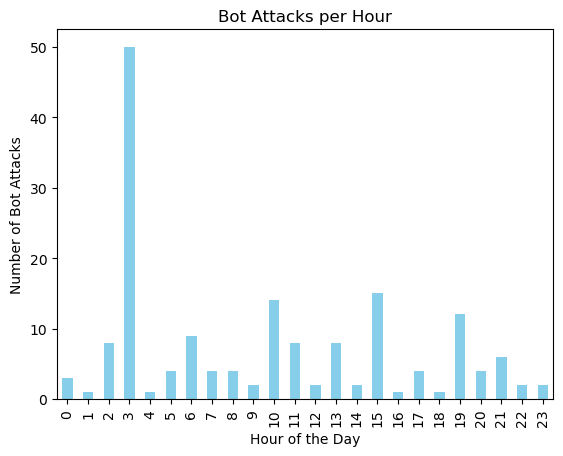

In [33]:
# plot bot attacks per hour (grouping the TimeGenerated [Local Time] column by hour and counting the number of bot attacks)
import matplotlib.pyplot as plt

waf_logs_df[waf_logs_df['Description'].str.contains('bot', case=False, na=False)].groupby(waf_logs_df['TimeGenerated [Local Time]'].dt.hour)['Description'].count().plot(kind='bar', color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Bot Attacks')
plt.title('Bot Attacks per Hour')
plt.show()

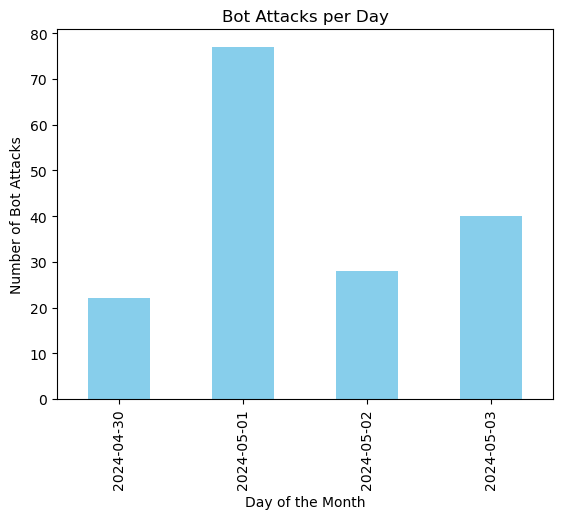

In [34]:
# same plot but per day
waf_logs_df[waf_logs_df['Description'].str.contains('bot', case=False, na=False)].groupby(waf_logs_df['TimeGenerated [Local Time]'].dt.date)['Description'].count().plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Bot Attacks')
plt.title('Bot Attacks per Day')
plt.show()

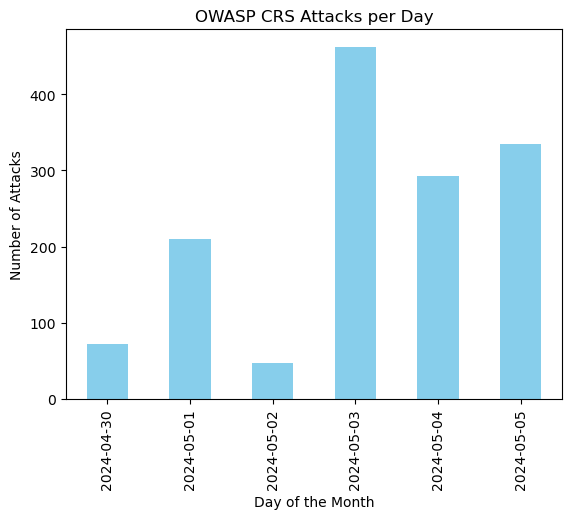

In [30]:

waf_logs_df[waf_logs_df['RuleSetType']=='OWASP CRS'].groupby(waf_logs_df['TimeGenerated [Local Time]'].dt.date)['Description'].count().plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Attacks')
plt.title('OWASP CRS Attacks per Day')
plt.show()

Text(0.5, 1.0, 'Top 5 OWASP CRS Attacks per Day')

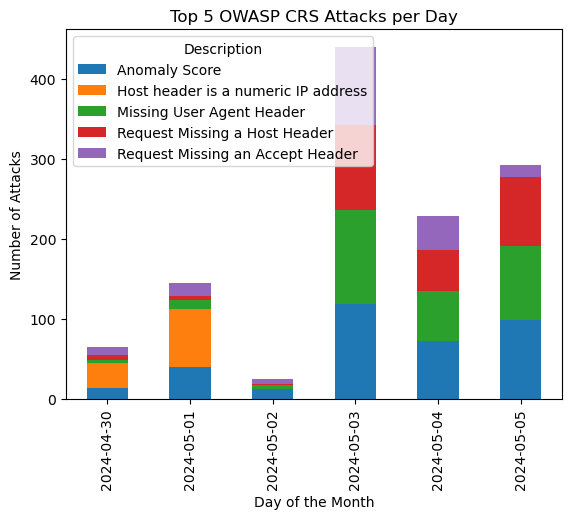

In [31]:
waf_OWASP_CRS = waf_logs_df[waf_logs_df['RuleSetType']=='OWASP CRS']
waf_OWASP_CRS['Description'].value_counts()
# extract the top 5 attacks from OWASP CRS
top_5_OWASP_CRS_attacks = waf_OWASP_CRS['Description'].value_counts().head(5)
# filter the waf_OWASP_CRS DataFrame to include only the top 5 attacks
waf_OWASP_CRS = waf_OWASP_CRS[waf_OWASP_CRS['Description'].isin(top_5_OWASP_CRS_attacks.index)]
#plot the  attacks per day
waf_OWASP_CRS.groupby([waf_OWASP_CRS['TimeGenerated [Local Time]'].dt.date, waf_OWASP_CRS['Description']])['Description'].count().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Day of the Month')
plt.ylabel('Number of Attacks')
plt.title('Top 5 OWASP CRS Attacks per Day')


Text(0.5, 1.0, 'Top 5 OWASP CRS Attacks per Hour')

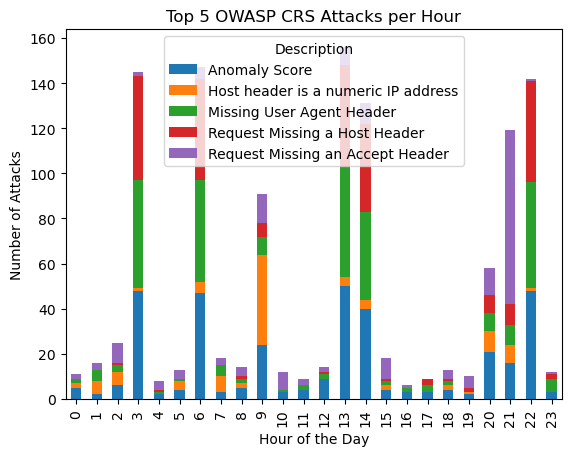

In [32]:
#plot the  attacks per hour
waf_OWASP_CRS.groupby([waf_OWASP_CRS['TimeGenerated [Local Time]'].dt.hour, waf_OWASP_CRS['Description']])['Description'].count().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Attacks')
plt.title('Top 5 OWASP CRS Attacks per Hour')
